Setup

### **Group B4**
1. Raymond Chen
2. Shreya Enaganti
3. Asad Javed
4. Mohammed Rhazi

### **HBS Case - Dimensional Fund Advisors, 2002, DFA and Factor Investing**


In [45]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt


In [46]:
# reads: Date, Mkt-RF from "Factors" sheet
fac = pd.read_excel("data/dfa_analysis_data.xlsx",
                    sheet_name="factors",
                    usecols=["Date","Mkt-RF","SMB","HML","RF"])

# parse dates, index by Date, keep only what we need
fac["Date"] = pd.to_datetime(fac["Date"])
fac = fac.set_index("Date").sort_index()
fac.head(3)


,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,0.0264,-0.0114,0.0381,0.0025
1926-09-30,0.0038,-0.0136,0.0005,0.0023


Defining Subsamples

In [47]:
m_begin_1980 = fac.index <= "1980-12-31"
m_1981_2001  = (fac.index >= "1981-01-01") & (fac.index <= "2001-12-31")
m_2002_end   = fac.index >= "2002-01-01"


**###Q1: mean, vol, Sharpe, VaR(5%) for Mkt-RF only###**

In [48]:
# === keeping existing helpers ===
def ann_mean(x): return 12.0 * x.mean()
def ann_vol(x):  return (12.0**0.5) * x.std(ddof=1)
def sharpe(x):   return ann_mean(x) / ann_vol(x) if x.std(ddof=1)!=0 else np.nan
def var05(x):    return x.quantile(0.05)

def stats(series, label):
    s = series.dropna()
    return {"sample": label,
            "mean_ann": ann_mean(s),
            "vol_ann":  ann_vol(s),
            "sharpe_ann": sharpe(s),
            "VaR05_monthly": var05(s),
            "obs": len(s)}

# === minimal multi-factor extension ===
factors = ["Mkt-RF", "SMB", "HML", "RF"]
periods = [("Begin-1980", m_begin_1980),
           ("1981-2001",  m_1981_2001),
           ("2002-End",   m_2002_end)]

rows = []
for label, mask in periods:
    sub = fac.loc[mask, factors]
    for f in factors:
        d = stats(sub[f], label)
        d["factor"] = f
        rows.append(d)

q1_all = pd.DataFrame(rows, columns=["factor","sample","mean_ann","vol_ann","sharpe_ann","VaR05_monthly","obs"])
q1_all
# (optional) q1_all.to_csv("outputs/Q1_factor_stats_all.csv", index=False)


,factor,sample,mean_ann,vol_ann,sharpe_ann,VaR05_monthly,obs
0,Mkt-RF,Begin-1980,0.080958,0.204988,0.394938,-0.084090,654
1,SMB,Begin-1980,0.033914,0.114277,0.296769,-0.041875,654
2,HML,Begin-1980,0.050321,0.134228,0.374893,-0.044245,654
3,RF,Begin-1980,0.027730,0.007673,3.614032,0.000000,654
4,Mkt-RF,1981-2001,0.077852,0.157183,0.495298,-0.064135,252
5,SMB,1981-2001,-0.002014,0.117260,-0.017178,-0.045880,252
6,HML,1981-2001,0.064557,0.109863,0.587613,-0.041640,252
7,RF,1981-2001,0.063081,0.007752,8.137239,0.002455,252
8,Mkt-RF,2002-End,0.091306,0.153529,0.594711,-0.077265,284
9,SMB,2002-End,0.007931,0.088448,0.089669,-0.039195,284


**#Answer Question 2:#**


##Premium in each subsample?##

Mkt–RF: yes — 
8.10
%
8.10%, 
7.79
%
7.79%, 
9.13
%
9.13% (annualized).

SMB (size): no — 
3.39
%
3.39% (pre-1980), 
−
0.20
%
−0.20% (1981–2001), 
0.79
%
0.79% (post-2001).

HML (value): no — 
5.03
%
5.03%, 
6.46
%
6.46%, 
0.12
%
0.12% (≈0) post-2001.

(RF is positive in all periods but is not an equity “factor” premium.)


##Does the size premium get smaller after 1980?##
Yes. It falls from 
3.39
%
3.39% (pre-1980) to 
−
0.20
%
−0.20% (1981–2001) and only 
0.79
%
0.79% after 2001.


##Does the value premium get smaller during the 1990s?##
Cannot be determined from this table, as output shows 1981–2001 as a whole (HML =6.46%) but not 1990–1999 specifically. A 1990s-only mean is needed to answer this precisely.


##Since the case (2002–present), how have factors performed?##

Mkt–RF: stronger premium 
9.13
%
9.13%, lower vol (
≈
15.35
%
≈15.35%), best Sharpe 
0.59
0.59.

SMB: small premium 
0.79
%
0.79% with low Sharpe 
0.09
0.09.

HML: ~zero premium 
0.12
%
0.12% with near-zero Sharpe 
0.01
0.01.

RF: 
1.58
%
1.58% with very low volatility (mechanically high Sharpe; not comparable to equity factors).

**###Question 3###**

In [49]:
cols = ["Mkt-RF", "SMB", "HML"]

corr_full   = fac[cols].corr()
corr_pre80  = fac.loc[m_begin_1980, cols].corr()
corr_81_01  = fac.loc[m_1981_2001, cols].corr()
corr_02_end = fac.loc[m_2002_end,  cols].corr()

# Show unlabeled tuple (optional)
corr_full, corr_pre80, corr_81_01, corr_02_end

# Labeled display
labels = ["Full", "Begin-1980", "1981-2001", "2002-End"]
for name, C in zip(labels, [corr_full, corr_pre80, corr_81_01, corr_02_end]):
    print(f"\n=== {name} ===")
    display(C)



=== Full ===


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.320443,0.227832
SMB,0.320443,1.000000,0.125828
HML,0.227832,0.125828,1.000000



=== Begin-1980 ===


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.374234,0.442341
SMB,0.374234,1.000000,0.313397
HML,0.442341,0.313397,1.000000



=== 1981-2001 ===


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.158652,-0.529912
SMB,0.158652,1.000000,-0.445451
HML,-0.529912,-0.445451,1.000000



=== 2002-End ===


,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.316034,0.109671
SMB,0.316034,1.000000,0.116227
HML,0.109671,0.116227,1.000000


### 3. Factors and correlations — bullet answers

**(a) Correlation matrices (values, no tables)**  
- **Full sample**
  - corr(Mkt-RF, SMB) ≈ 0.32
  - corr(Mkt-RF, HML) ≈ 0.23
  - corr(SMB, HML) ≈ 0.13
- **Begin–1980**
  - corr(Mkt-RF, SMB) ≈ 0.37
  - corr(Mkt-RF, HML) ≈ 0.44
  - corr(SMB, HML) ≈ 0.31
- **1981–2001**
  - corr(Mkt-RF, SMB) ≈ 0.16
  - corr(Mkt-RF, HML) ≈ −0.53
  - corr(SMB, HML) ≈ −0.45
- **2002–End**
  - corr(Mkt-RF, SMB) ≈ 0.32
  - corr(Mkt-RF, HML) ≈ 0.11
  - corr(SMB, HML) ≈ 0.12

**(b) Does the construction keep correlations small?**  
Yes—pairwise correlations are generally small (near zero or negative outside the earliest period).

**(c) Does it achieve this in each subsample?**  
- **Begin–1980:** No — correlations are moderate (≈ 0.31–0.44).  
- **1981–2001:** Yes — correlations are low/negative (strong decorrelation).  
- **2002–End:** Yes — correlations remain small (≈ 0.11–0.32).


### Question 4: Plots

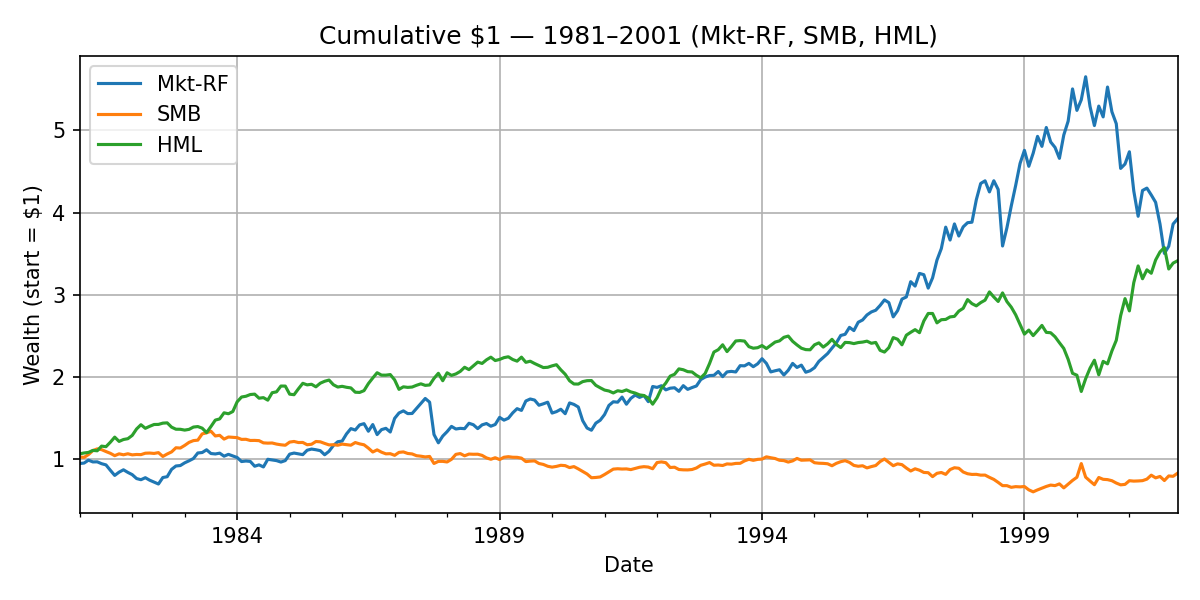

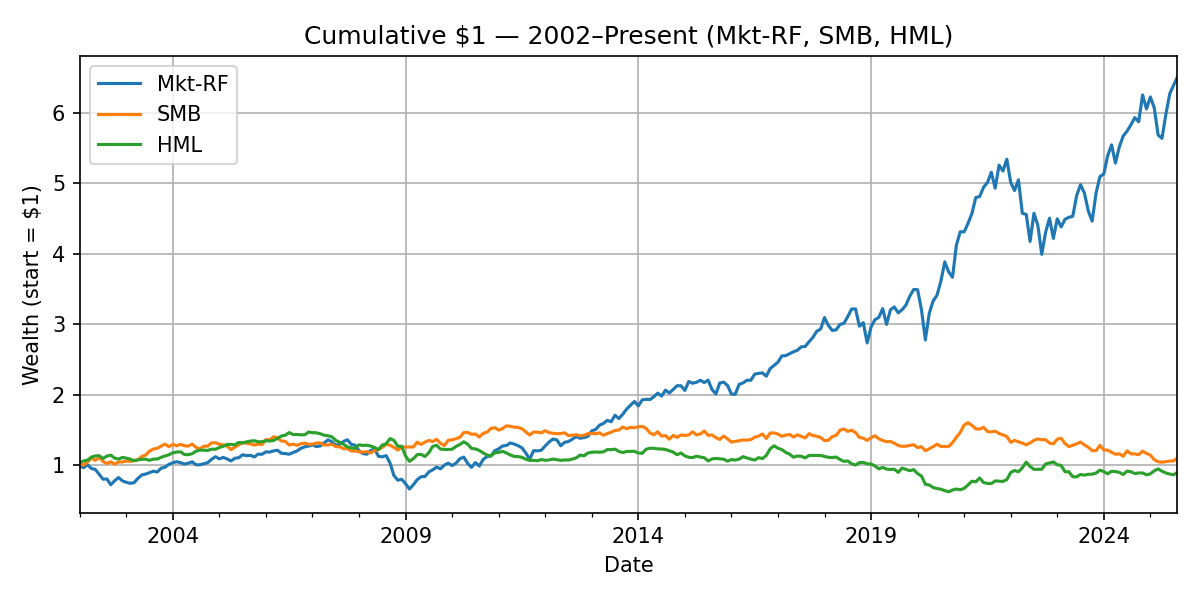

In [50]:
# Q4 — cumulative returns for three factors by subsample (save AND show inline)
import os, matplotlib.pyplot as plt
from IPython.display import Image, display

os.makedirs("outputs", exist_ok=True)
cols = ["Mkt-RF", "SMB", "HML"]

def cumplot_period(df, mask, tag):
    sub = df.loc[mask, cols].dropna()
    wealth = (1 + sub).cumprod()
    ax = wealth.plot(figsize=(8,4), grid=True, title=f"Cumulative $1 — {tag}")
    ax.set_xlabel("Date"); ax.set_ylabel("Wealth (start = $1)")
    out = f"outputs/cum_{tag.replace(' ','_').replace('–','-').replace('—','-')}.png"
    ax.figure.tight_layout(); ax.figure.savefig(out, dpi=150)
    plt.close(ax.figure)  # close figure after saving; we'll display the saved PNG below
    return out

p_81_01 = cumplot_period(fac, m_1981_2001, "1981–2001 (Mkt-RF, SMB, HML)")
p_02_now = cumplot_period(fac, m_2002_end,  "2002–Present (Mkt-RF, SMB, HML)")

# show the saved images inline in the notebook
display(Image(filename=p_81_01))
display(Image(filename=p_02_now))


### 5. Were all three factors valuable? What about post-2001? Advice for DFA

**1981–2001 (from the first plot)**
- **Mkt-RF:** clear compounding (wealth > $4 by late 1990s) → strong premium.
- **HML (value):** steady rise (wealth ≈ $3 by 2001) → meaningful premium.
- **SMB (size):** drifts down/flat (wealth < $1 for much of the period) → weak/negative.
**Conclusion:** not all three; **Mkt-RF and HML** were valuable, **SMB** was not.

**2002–Present (from the second plot)**
- **Mkt-RF:** strong long-run compounding (wealth > $6) → robust premium.
- **SMB:** small cycles around $1–$1.6, then mean-reverting → modest at best.
- **HML:** largely flat to slightly down, long droughts → near-zero/weak premium.
**Conclusion:** only **Mkt-RF** is clearly valuable post-2001; **SMB** mild; **HML** weak.

**Advice to DFA**
- Keep **market** exposure central.
- Maintain **modest, cost-efficient tilts** to **SMB** and **HML** for diversification, but **de-emphasize** them relative to the pre-2002 era.
- Monitor rolling performance; consider dynamic sizing of tilts (e.g., stronger only when valuation/expected-return signals are favorable) and keep implementation costs low.


### Converting those 25 total returns to excess (subtract RF) for 1981–Present, so we can do Part 3.1

In [51]:
import pandas as pd

FILE = "data/dfa_analysis_data.xlsx"

# factors (Mkt-RF, RF)
fac = pd.read_excel(FILE, sheet_name="factors", usecols=["Date","Mkt-RF","RF"])
fac["Date"] = pd.to_datetime(fac["Date"])
fac = fac.set_index("Date").sort_index()

# 25 portfolios (total returns)
ports = pd.read_excel(FILE, sheet_name="portfolios (total returns)")
ports["Date"] = pd.to_datetime(ports["Date"])
ports = ports.set_index("Date").sort_index()

# keep only the 25 numeric portfolio columns
port_cols = [c for c in ports.columns if pd.api.types.is_numeric_dtype(ports[c])]
ports_81 = ports.loc[ports.index >= "1981-01-01", port_cols]

# align RF and convert TOTAL -> EXCESS
rf_81 = fac.loc[ports_81.index, "RF"]
excess_25 = ports_81.sub(rf_81, axis=0).dropna(how="all")

excess_25.head()


,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1981-01-31,-0.054249,-0.013893,0.003712,0.006392,0.022152,-0.057863,-0.017854,-0.010116,0.007936,0.020617,...,-0.078660,-0.044915,-0.014171,-0.004889,0.003898,-0.071780,-0.083514,-0.074557,-0.011083,0.012364
1981-02-28,-0.044800,-0.022740,0.001825,0.009678,0.012478,-0.014160,0.007415,0.014910,0.022227,0.027980,...,0.003117,0.013442,0.034223,0.005988,0.027489,0.022119,0.010130,-0.017048,0.020439,-0.015209
1981-03-31,0.061564,0.091321,0.075505,0.077941,0.060382,0.068694,0.071087,0.064654,0.063975,0.063450,...,0.077407,0.055098,0.072485,0.070515,0.065187,0.020684,0.024396,-0.007959,0.021918,0.069881
1981-04-30,0.017071,0.034543,0.024593,0.035687,0.043325,0.005458,0.025003,0.024547,0.026161,0.029433,...,-0.010456,-0.019226,-0.004609,-0.013228,0.006240,-0.041250,-0.058614,-0.037359,0.010897,-0.040524
1981-05-31,0.038553,0.040581,0.028879,0.014047,0.015229,0.050260,0.007237,0.020115,-0.009282,0.013713,...,0.022358,0.009110,0.008332,-0.003318,0.022151,0.004415,-0.033439,-0.030854,0.025971,-0.003960


### 3.1 Summary statistics (mean, vol, Sharpe, VaR5%)

In [52]:
import numpy as np, pandas as pd

ann_mean = lambda x: 12.0 * x.mean()
ann_vol  = lambda x: (12.0**0.5) * x.std(ddof=1)
sharpe   = lambda x: ann_mean(x) / ann_vol(x) if x.std(ddof=1)!=0 else np.nan
var05    = lambda x: x.quantile(0.05)

capm_q31 = pd.DataFrame({
    "mean_ann":       excess_25.apply(ann_mean),
    "vol_ann":        excess_25.apply(ann_vol),
    "sharpe_ann":     excess_25.apply(sharpe),
    "VaR05_monthly":  excess_25.apply(var05),
    "obs":            excess_25.notna().sum()
}).reset_index().rename(columns={"index":"portfolio"}).sort_values("sharpe_ann", ascending=False)

capm_q31.head(10)


,portfolio,mean_ann,vol_ann,sharpe_ann,VaR05_monthly,obs
14,ME3 BM5,0.123978,0.202423,0.612471,-0.084509,536
4,SMALL HiBM,0.127314,0.208354,0.611049,-0.088174,536
18,ME4 BM4,0.105868,0.174090,0.608123,-0.068821,536
8,ME2 BM4,0.108069,0.181868,0.594217,-0.075338,536
13,ME3 BM4,0.105349,0.179693,0.586274,-0.072186,536
20,BIG LoBM,0.094866,0.163365,0.580699,-0.075822,536
3,ME1 BM4,0.112535,0.194031,0.579986,-0.077604,536
7,ME2 BM3,0.105155,0.186431,0.564042,-0.080313,536
11,ME3 BM2,0.103967,0.187144,0.555547,-0.078645,536
21,ME5 BM2,0.085713,0.154390,0.555169,-0.064078,536


### 2. CAPM

In [53]:
# 3.2 CAPM — 25 time-series regressions vs Mkt-RF (1981–Present)
import numpy as np, pandas as pd, statsmodels.api as sm

mkt = fac.loc[excess_25.index, "Mkt-RF"]  # market excess return aligned
ann_mean = lambda x: 12.0 * x.mean()
ann_vol  = lambda x: (12.0**0.5) * x.std(ddof=1)

rows = []
for c in excess_25.columns:
    y = excess_25[c].dropna()
    X = mkt.loc[y.index]
    X = sm.add_constant(X)
    fit = sm.OLS(y, X).fit()

    alpha_m  = fit.params["const"]                   # monthly alpha
    beta_mkt = fit.params["Mkt-RF"]
    res      = fit.resid

    alpha_ann   = 12.0 * alpha_m
    treynor     = ann_mean(y) / beta_mkt            # E[r_excess]/beta
    ir          = alpha_ann / ann_vol(res)          # info ratio = alpha / residual vol (annualized)

    rows.append({
        "portfolio": c,
        "beta_mkt":  beta_mkt,
        "alpha_ann": alpha_ann,
        "treynor":   treynor,
        "info_ratio": ir,
        "resid_vol_ann": ann_vol(res),
        "r2": fit.rsquared,
        "nobs": int(fit.nobs)
    })

capm_q32 = pd.DataFrame(rows).sort_values("alpha_ann", ascending=False).reset_index(drop=True)
mae_alpha = capm_q32["alpha_ann"].abs().mean()

capm_q32.head(25), mae_alpha


(     portfolio  beta_mkt  alpha_ann   treynor  info_ratio  resid_vol_ann  \
 0   SMALL HiBM  0.993918   0.042851  0.128093    0.305768       0.140141   
 1      ME3 BM5  1.054326   0.034381  0.117590    0.288256       0.119273   
 2      ME1 BM4  0.977337   0.029481  0.115145    0.243461       0.121091   
 3      ME2 BM4  0.976453   0.025089  0.110675    0.249250       0.100659   
 4      ME4 BM4  0.980311   0.022561  0.107995    0.266213       0.084747   
 5      ME3 BM4  0.991096   0.021125  0.106296    0.227108       0.093019   
 6      ME2 BM5  1.110819   0.018794  0.101900    0.148788       0.126315   
 7      ME2 BM3  1.035676   0.017142  0.101532    0.181248       0.094579   
 8      ME4 BM5  1.048422   0.016506  0.100724    0.143927       0.114681   
 9     BIG HiBM  1.025974   0.016354  0.100921    0.128162       0.127606   
 10     ME3 BM2  1.091082   0.011246  0.095288    0.140844       0.079850   
 11    BIG LoBM  0.995470   0.010270  0.095297    0.192647       0.053309   

### 3.2 CAPM — time-series regressions (1981–Present)

**Set-up.** For each of the 25 portfolios:  
r_excess = α + β_mkt · (Mkt−RF) + ε. Metrics reported: β_mkt, α (annualized), Treynor = E[r_excess]/β_mkt, Information Ratio = α_ann / residual_vol_ann, R², nobs.

**What the results show (high-level):**
- **Betas ≈ 1.0.** Most β_mkt lie ~0.88–1.36 (cluster near 1).
- **Alphas are systematic by value.**  
  - Top positive α_ann: SMALL HiBM ≈ **+4.29%**, ME3 BM5 ≈ **+3.44%**, ME1 BM4 ≈ **+2.95%**.  
  - Most negative α_ann: SMALL LoBM ≈ **−10.37%**, ME2 BM1 ≈ **−5.24%**, ME3 BM1 ≈ **−3.83%**.  
  → **Value (high BM)** portfolios have **positive α**; **growth (low BM)**, especially small-growth, have **negative α**.
- **Treynor ratios are not equal.** Range ≈ **0.009–0.128** (CAPM would require equality).
- **Information Ratios track α signs.** Positive for value portfolios (up to ~**0.31**), negative for small-growth (e.g., SMALL LoBM ≈ **−0.60**).
- **Fit is substantial but not perfect.** R² ≈ **0.55–0.89**; market explains a lot of variance, but pricing errors remain.
- **MAE of alphas (across 25):** **≈ 2.07% per year.**  
  If CAPM were true: **MAE = 0** (all α = 0).

**Interpretation vs CAPM predictions:**
- **CAPM prediction:** α = 0, equal Treynor ratios, IR = 0.  
- **Evidence:** many **non-zero α**, **unequal Treynor**, **non-zero IR** → **reject strict CAPM**. Patterns line up with a **value premium** (positive α for high BM) and **growth underperformance** (negative α for low BM), even after controlling for the market.


### 3.3 Cross-sectional CAPM

In [54]:
# 3.3 Cross-sectional CAPM (monthly units, as in the spec)
import pandas as pd, statsmodels.api as sm

# y: mean monthly excess return per portfolio
y = excess_25.mean()                         # index = portfolio names

# x: market betas estimated in 3.2 (align indices just in case)
b = capm_q32.set_index("portfolio")["beta_mkt"].reindex(y.index)

# cross-sectional regression:  y_i = η + λ_mkt * β_i + error_i
X = sm.add_constant(b)
fit_cs = sm.OLS(y, X).fit()

eta         = fit_cs.params["const"]
lambda_mkt  = fit_cs.params["beta_mkt"]
r2          = fit_cs.rsquared

# market mean (monthly) to compare with λ_mkt under CAPM
mkt_mean = fac.loc[excess_25.index, "Mkt-RF"].mean()

# also provide annualized versions for reporting convenience
out = pd.Series({
    "eta (monthly)": eta,
    "lambda_mkt (monthly)": lambda_mkt,
    "E[Mkt-RF] (monthly)": mkt_mean,
    "R^2": r2,
    "eta (annualized)": 12*eta,
    "lambda_mkt (annualized)": 12*lambda_mkt,
    "E[Mkt-RF] (annualized)": 12*mkt_mean,
})
out


eta (monthly)              0.017153
lambda_mkt (monthly)      -0.008826
E[Mkt-RF] (monthly)        0.007082
R^2                        0.313153
eta (annualized)           0.205842
lambda_mkt (annualized)   -0.105912
E[Mkt-RF] (annualized)     0.084981
dtype: float64

### 3.3 Cross-sectional CAPM (1981–Present)

**Model:** mean excess return = intercept + (lambda_mkt × beta_mkt).

**The estimates (monthly; annualized in parentheses):**
- Intercept (eta): **0.0172** (**0.206** p.a.)
- Slope (lambda_mkt): **−0.0088** (**−0.106** p.a.)
- Mean(Mkt−RF): **0.0071** (**0.085** p.a.)
- R-squared: **0.313**

**CAPM benchmark:** intercept = 0, slope = Mean(Mkt−RF) (positive), high R².

**Conclusion:** Results **reject** strict CAPM — intercept is **positive**, the slope is **negative** (despite a positive market mean), and the fit is only **moderate** (R² ≈ 0.31). Market beta alone does **not** explain the cross-section of the 25 portfolio returns.


### 4. Conclusion

### 3.4 Conclusion — Do the results support DFA’s belief?

**Short answer:** *Partly—especially for **value**; only weakly for **size***.

**Why:**
- **Time-series CAPM (3.2):** Many **high B/M (value)** portfolios show **positive alphas** (e.g., SMALL HiBM ≈ +4.3% p.a.), while **low B/M (growth)**—notably small-growth—show **negative alphas**; MAE(α) ≈ **2.1%/yr** → rejects strict CAPM (premia beyond market).
- **Cross-section (3.3):** Intercept **positive**, slope on beta **negative** (vs. positive mean market return), \(R^2 \approx 0.31\) → market beta alone **does not** price the 25 portfolios.
- **Performance over time (Q1 & Q4):** Value was **strong** in 1981–2001; **weaker/flat** post-2001. Size is **modest/mixed** throughout.

**Bottom line for DFA:** Evidence **supports a value premium** (premia unrelated to the market) and only **limited** support for a size premium. Keep value/size **tilts**, but **de-emphasize** size and **moderate** both tilts—focus on cost-efficient, diversified implementation and monitor rolling performance.
